# ✅ Test Environnement Deep Learning

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles

from tqdm import tqdm

plt.style.use('dark_background')  # 🕶️ Dark mode
plt.rcParams.update({
    "figure.facecolor":  (0.12 , 0.12, 0.12, 1),
    "axes.facecolor": (0.12 , 0.12, 0.12, 1),
})

dimension de X:  (2, 100)
dimension de y:  (1, 100)


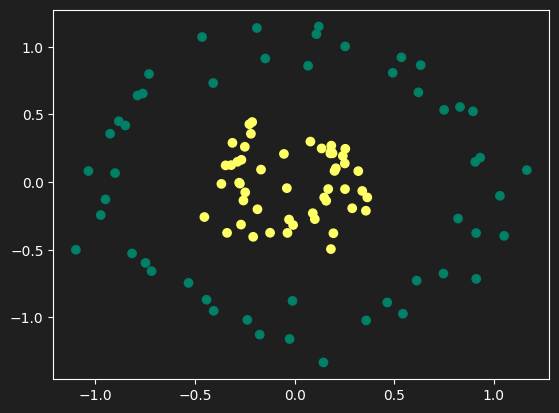

In [37]:
X, y = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=0)

X = X.T
y = y.reshape(1, y.shape[0])

print('dimension de X: ', X.shape)
print('dimension de y: ', y.shape)

plt.scatter(X[0, :], X[1, :], c=y, cmap='summer')
plt.show()

In [38]:
def initialisation(dimensions):

    C = len(dimensions)
    parametres = {}

    for c in range(1, C):
        parametres['W' + str(c)] = np.random.randn(dimensions[c], dimensions[c - 1])
        parametres['b' + str(c)] = np.random.randn(dimensions[c], 1)
        
    return parametres

In [39]:
parametres = initialisation([2, 32, 32, 1])

for key, val in parametres.items():
    print(key, val.shape)

W1 (32, 2)
b1 (32, 1)
W2 (32, 32)
b2 (32, 1)
W3 (1, 32)
b3 (1, 1)


In [56]:
def forward_propagation(X, parametres):
    
    activations = {'A0': X}

    C = len(parametres) // 2
    
    for c in range(1, C + 1):
        Z = parametres['W' + str(c)].dot(activations['A' + str(c - 1)]) + parametres['b' + str(c)]
        activations['A' + str(c)] = 1 / (1 + np.exp(-np.clip(Z, -500, 500)))
        
        

    return activations

In [57]:
activations = forward_propagation(X, parametres)

for key, val in activations.items():
    print(key, val.shape)

A0 (2, 100)
A1 (32, 100)
A2 (32, 100)
A3 (32, 100)
A4 (1, 100)


In [58]:
def log_loss(y, A):
    epsilon = 1e-15
    return 1/len(y) * np.sum(-y * np.log(A + epsilon) - (1 - y) * np.log(1 - A + epsilon))
    

In [59]:
def back_propagation(X, y, activations, parametres):


    C = len(parametres) // 2
    m = y.shape[1]

    dZ = activations['A' + str(C)] - y

    gradients = {}

    for c in reversed(range(1, C + 1)):
        gradients['dW' + str(c)] = 1 / m * np.dot(dZ, activations['A' + str(c-1)].T)
        gradients['db' + str(c)] = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        if c > 1:
            dZ = np.dot(parametres['W' + str(c)].T, dZ) * activations['A' + str(c - 1)] * (1 - activations['A' + str(c - 1)])
        

    return gradients
    



In [60]:
gradients = back_propagation(X, y, activations, parametres)

for key, val in gradients.items():
    print(key, val.shape)

dW4 (1, 32)
db4 (1, 1)
dW3 (32, 32)
db3 (32, 1)
dW2 (32, 32)
db2 (32, 1)
dW1 (32, 2)
db1 (32, 1)


In [61]:
def update(gradients, parametres, learning_rate):

    C = len(parametres) // 2



    for c in range(1, C + 1):
        parametres['W' + str(c)] = parametres['W' + str(c)]  + learning_rate * gradients['dW' + str(c)] 
        parametres['b' + str(c)] = parametres['b' + str(c)]  + learning_rate * gradients['db' + str(c)]         
        
        
    return parametres

In [62]:
parametres = update(gradients, parametres, learning_rate=0.1)

for key, val in parametres.items():
    print(key, val.shape)

W1 (32, 2)
b1 (32, 1)
W2 (32, 32)
b2 (32, 1)
W3 (32, 32)
b3 (32, 1)
W4 (1, 32)
b4 (1, 1)


In [68]:
def predict(X, parametres):
    activations = forward_propagation(X, parametres)
    C = len(parametres) // 2
    
    A = activations['A' + str(C)]
    return A > 0.5
       

In [69]:
from sklearn.metrics import accuracy_score

In [99]:
def visualization(X, y, parameters, axis):
    """Visualize decision boundary for 2D data"""
    if X.shape[0] == 2:  # Only for 2D feature space
        h = 0.02  # Step size in mesh
        x_min, x_max = X[0,:].min()-1, X[0,:].max()+1
        y_min, y_max = X[1,:].min()-1, X[1,:].max()+1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                           np.arange(y_min, y_max, h))
        
        # Prepare grid points for prediction
        grid_points = np.c_[xx.ravel(), yy.ravel()].T
        Z = predict(grid_points, parameters)
        Z = Z.reshape(xx.shape)
        
        # Use axis.contourf (not the array's method)
        contour = axis.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
        scatter = axis.scatter(X[0,:], X[1,:], c=y.ravel(), 
                             edgecolors='k', cmap=plt.cm.coolwarm)
        axis.set_title('Decision Boundary')
        plt.colorbar(contour, ax=axis)
    else:
        # Alternative visualization for high-D data
        axis.plot(y.ravel(), label='True')
        axis.plot(predict(X, parameters), '--', label='Predicted')
        axis.legend()
        axis.set_title('Predictions vs True')


In [107]:
def neural_network(X_train, y_train, hidden_layers = (32, 32, 32), learning_rate = 0.1, n_iter = 100):
    np.random.seed(0)
    # initialisation W, b
    dimensions = list(hidden_layers)
    dimensions.insert(0, X_train.shape[0])
    dimensions.append(y_train.shape[0])
    parametres = initialisation(dimensions)

    train_loss = []
    train_acc = []
    
    

    for i in tqdm(range(n_iter)):
        # activations
        activations = forward_propagation(X_train, parametres)

        # mise à jour
        gradients = back_propagation(X_train, y_train, activations, parametres)
        parametres = update(gradients, parametres, learning_rate)

        if i % 10:
            
            # Train
            C = len(parametres) // 2
            train_loss.append(log_loss(y_train, activations['A' + str(C)]))
            y_pred = predict(X_train, parametres)
            current_accuracy = accuracy_score(y_train.flatten(), y_pred.flatten()) # applatir les matrices
            train_acc.append(current_accuracy)            

    # Create figure
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    
    # Plot training curves
    ax[0].plot(train_loss)
    ax[0].set_title('Training Loss')
    
    ax[1].plot(train_acc)
    ax[1].set_title('Training Accuracy')
    
    # Add visualization
    visualization(X, y, parametres, ax[2])
    
    plt.tight_layout()
    plt.show()

    print("Train accuracy: ", np.max(train_acc))


    return parametres

In [108]:

def neural_network2(X_train, y_train, X_test, y_test, n1=4, learning_rate = 0.1, n_iter = 1000):
    # initialisation W, b
    n0 = X_train.shape[0]
    n2 = y_train.shape[0]
    np.random.seed(0)
    parametres = initialisation(n0, n1, n2)

    train_loss = []
    train_acc = []

    test_loss = []
    test_acc = []
    
    

    for i in tqdm(range(n_iter)):
        # activations
        activations = forward_propagation(X_train, parametres)

        # mise à jour
        gradients = back_propagation(X_train, y_train, activations, parametres)
        parametres = update(gradients, parametres, learning_rate)

        if i % 10:
            
            # Train
            train_loss.append(log_loss(y_train, activations['A2']))
            y_pred = predict(X_train, parametres)
            
            current_accuracy = accuracy_score(y_train.flatten(), y_pred.flatten()) # applatir les matrices
            train_acc.append(current_accuracy) 

            # Test
            activations = forward_propagation(X_test, parametres)
            test_loss.append(log_loss(y_test, activations['A2']))
            y_pred = predict(X_test, parametres)
            current_accuracy = accuracy_score(y_test.flatten(), y_pred.flatten()) # applatir les matrices
            test_acc.append(current_accuracy) 
            
            
    
    
    plt.figure(figsize=(14, 4))
    
    #  Train Loss
    plt.subplot(1, 3, 1)
    plt.plot(train_loss, label='train loss')
    plt.legend()

    #  Train Loss
    plt.subplot(1, 3, 2)
    plt.plot(test_loss, label='test loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(train_acc, label='train acc')
    plt.plot(test_acc, label='test acc')
    plt.legend()

    plt.show()

    print("Train accuracy: ", np.max(train_acc))
    print("Test accuracy: ", np.max(test_acc))
    
    

    return parametres

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1347.05it/s]


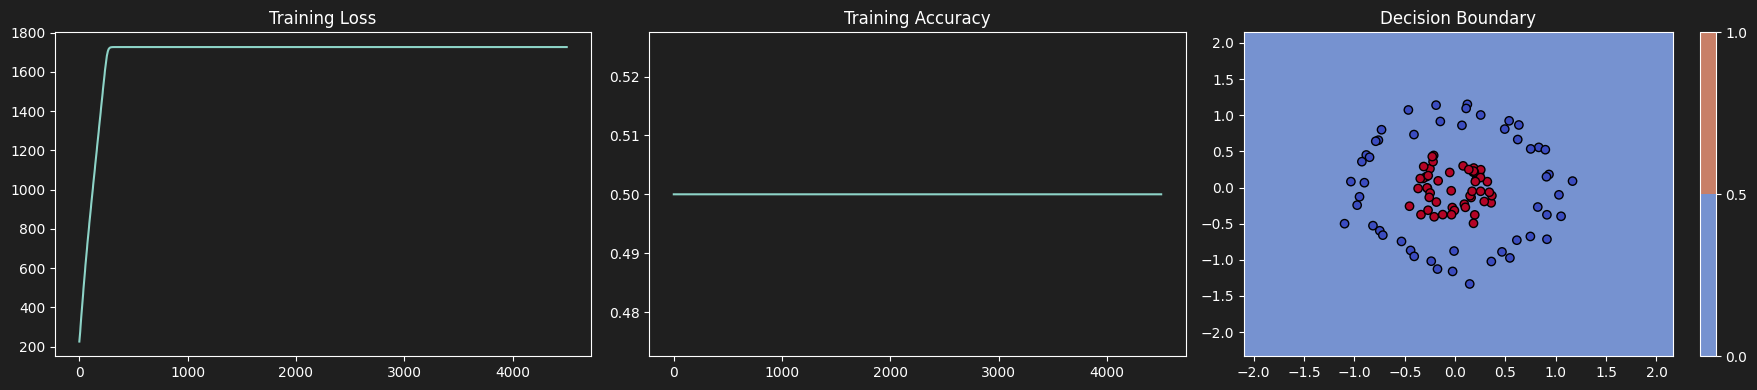

Train accuracy:  0.5


In [109]:
parametres = neural_network(X, y, n_iter=5000, learning_rate=0.01)

In [112]:
from utilities import *

In [113]:
X_train, y_train, X_test, y_test = load_data()

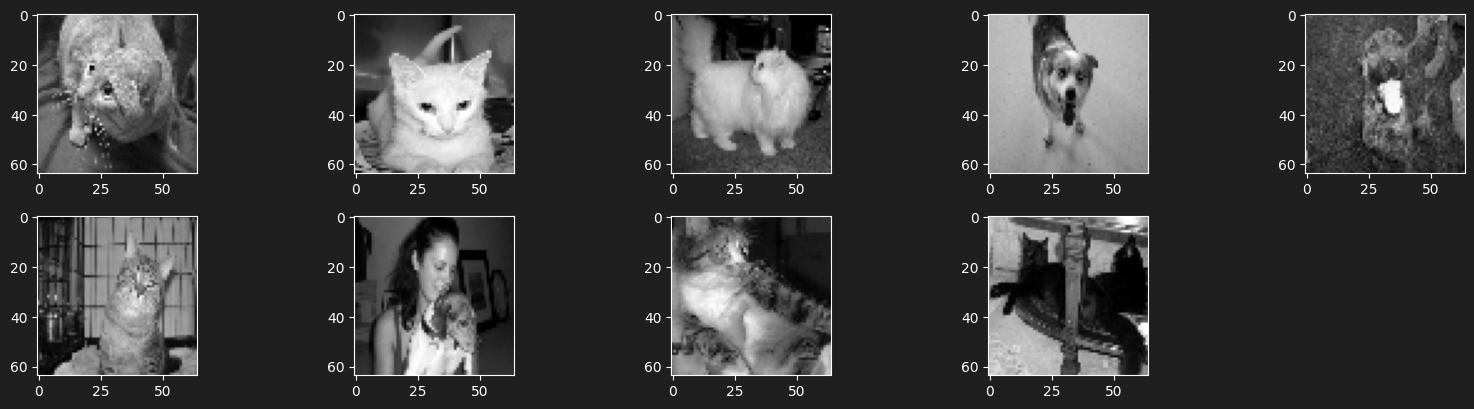

In [114]:
plt.figure(figsize=(16, 8))
for i in range(1, 10):
    plt.subplot(4,5,i)
    plt.imshow(X_train[i], cmap="gray")
    #plt.title(y_train[i])
    plt.tight_layout()
plt.show()

In [115]:
X_train, y_train, X_test, y_test = load_data()
y_train = y_train.T
y_test = y_test.T

X_train = X_train.T
X_train_reshape = X_train.reshape(-1, X_train.shape[-1]) / X_train.max()

X_test = X_test.T
X_test_reshape = X_test.reshape(-1, X_test.shape[-1]) / X_train.max()

m_train = 300
m_test = 80

X_test_reshape = X_test_reshape[:, :m_test]
X_train_reshape = X_train_reshape[:, :m_train]
y_train = y_train[:, :m_train]
y_test = y_test[:, :m_test]

print(X_train_reshape.shape)
print(X_test_reshape.shape)
print(y_train.shape)
print(y_test.shape)

(4096, 300)
(4096, 80)
(1, 300)
(1, 80)


In [116]:
parametres1 = neural_network2(
    X_train_reshape, y_train, X_test_reshape, y_test,
    n1 = 16, learning_rate = 0.01, n_iter = 5000
)

TypeError: initialisation() takes 1 positional argument but 3 were given

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:35<00:00, 23.18it/s]


ValueError: shapes (32,4096) and (2,48150) not aligned: 4096 (dim 1) != 2 (dim 0)

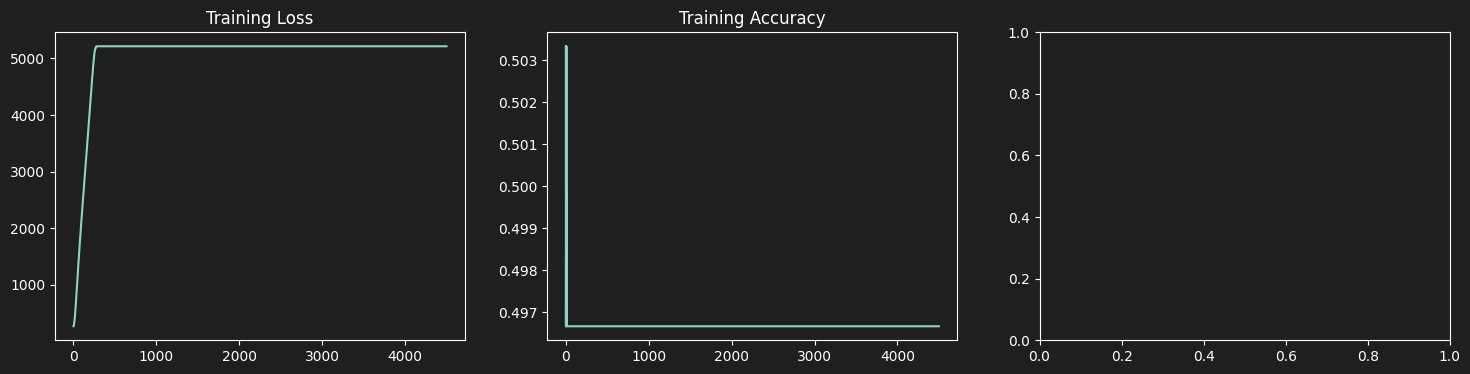

In [117]:
parametres = neural_network(X_train_reshape, y_train, n_iter=5000, learning_rate=0.01)